<a href="https://colab.research.google.com/github/ds-joy/ML-Practice/blob/master/potato_leaf_diseases/potato_diseases.ipynbpotato_diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dsjoy36","key":"16a0df8f4d38162031a75ac6a3be867c"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                     Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23           8711        270  1.0              
devansodariya/student-performance-data                       Student Performance Dataset                           7KB  2022-05-26 13:55:09           4400        147  0.9705882        
iamsouravbanerjee/software-professional-salaries-2022        Salary Dataset - 2022                               526KB  2022-06-15 17:13:05           1595         41  1.0              
paradisejoy/top-hits-spotify-from-20002019                   Top Hits Spoti

In [4]:
! kaggle datasets download -d arjuntejaswi/plant-village

 93% 305M/329M [00:01<00:00, 150MB/s]
100% 329M/329M [00:01<00:00, 176MB/s]


In [ ]:
!mkdir potato
!unzip plant-village.zip -d potato

In [6]:
!rm -rf /content/potato/PlantVillage/Pepper__bell___Bacterial_spot/
!rm -rf /content/potato/PlantVillage/Pepper__bell___healthy/

!rm -rf /content/potato/PlantVillage/Tomato_Bacterial_spot/
!rm -rf /content/potato/PlantVillage/Tomato_Early_blight/
!rm -rf /content/potato/PlantVillage/Tomato_Late_blight/
!rm -rf /content/potato/PlantVillage/Tomato_Leaf_Mold/
!rm -rf /content/potato/PlantVillage/Tomato_Septoria_leaf_spot/
!rm -rf /content/potato/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/
!rm -rf /content/potato/PlantVillage/Tomato__Target_Spot/
!rm -rf /content/potato/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/
!rm -rf /content/potato/PlantVillage/Tomato_healthy/
!rm -rf /content/potato/PlantVillage/Tomato__Tomato_mosaic_virus/


In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [8]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/potato/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
print(class_names)
print(len(dataset))

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
68


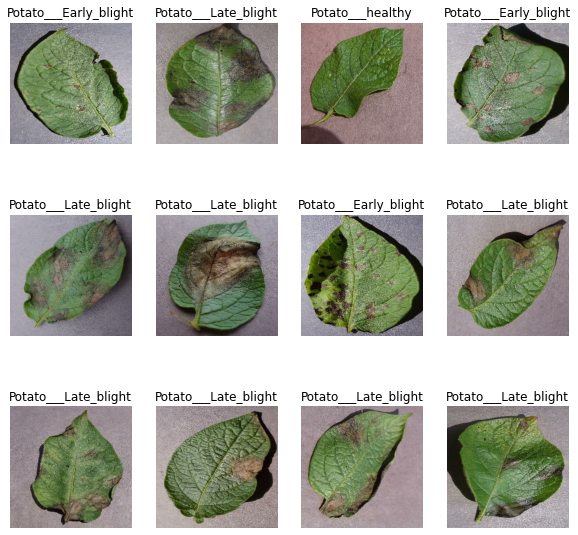

In [11]:
# for image_batch, label_batch in dataset.take(1):
    # print(image_batch.shape)
    # print(label_batch.numpy())
    # print("first image")
    # print(image_batch[0].shape)

    # visualization
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [12]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    


In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [15]:
# runtime optimization
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
# image preprocessing

# rescaling
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [17]:
#data_augmentation

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
# model training

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 31s 315ms/step - loss: 0.8927 - accuracy: 0.5156 - val_loss: 0.8744 - val_accuracy: 0.6771
Epoch 2/50
54/54 [==============================] - 15s 272ms/step - loss: 0.6016 - accuracy: 0.7407 - val_loss: 0.5881 - val_accuracy: 0.7083
Epoch 3/50
54/54 [==============================] - 16s 292ms/step - loss: 0.4245 - accuracy: 0.8264 - val_loss: 0.5596 - val_accuracy: 0.7969
Epoch 4/50
54/54 [==============================] - 15s 271ms/step - loss: 0.2821 - accuracy: 0.8872 - val_loss: 0.4118 - val_accuracy: 0.8125
Epoch 5/50
54/54 [==============================] - 15s 273ms/step - loss: 0.3222 - accuracy: 0.8594 - val_loss: 0.2786 - val_accuracy: 0.8854
Epoch 6/50
54/54 [==============================] - 15s 272ms/step - loss: 0.1936 - accuracy: 0.9300 - val_loss: 0.3634 - val_accuracy: 0.8021
Epoch 7/50
54/54 [==============================] - 15s 269ms/step - loss: 0.2048 - accuracy: 0.9282 - val_loss: 0.1109 - val_accuracy: 0.9583

In [23]:
score = model.evaluate(test_ds)

8/8 [==============================] - 2s 33ms/step - loss: 0.0329 - accuracy: 0.9883


In [25]:
score

[0.032908450812101364, 0.98828125]

In [28]:
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 50, 'steps': 54}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

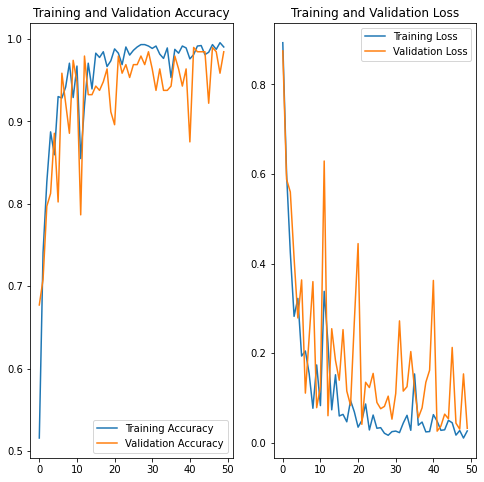

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


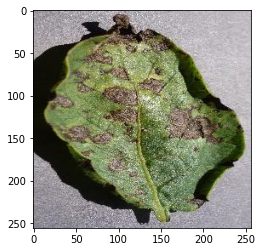

In [31]:
# Run prediction on a sample image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [32]:
# Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

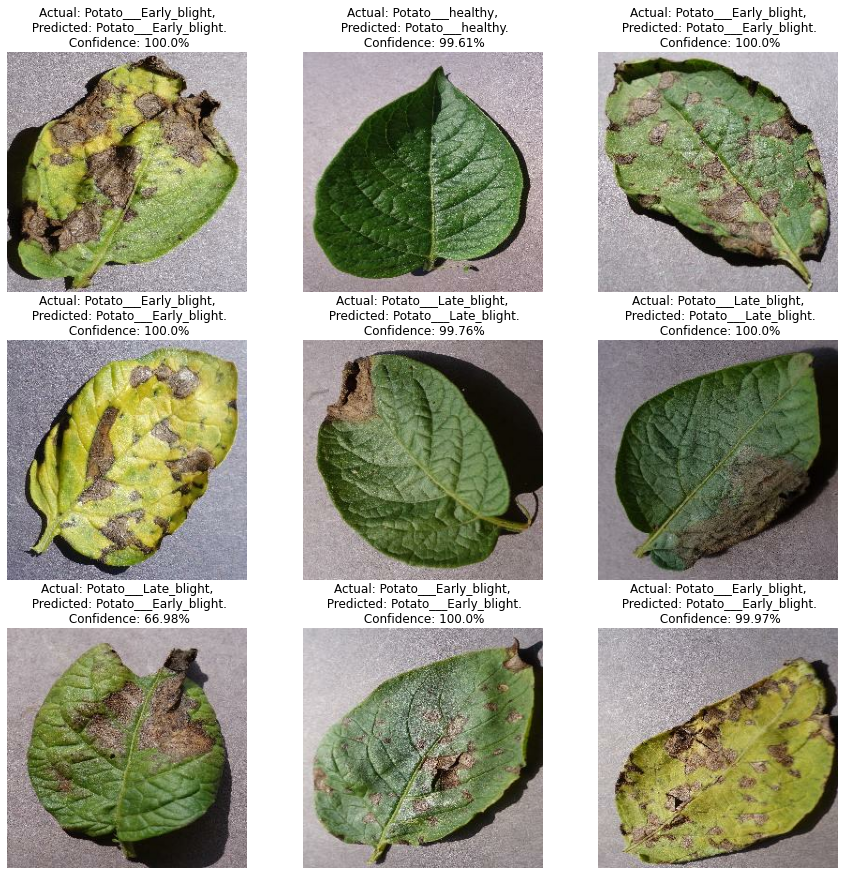

In [33]:
# Now run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
